# Continuous Control

---

Solution for project 2 of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### Packages

Import the necessary packages. If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import math
import time
from collections import deque

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from agent.agent import Agent, AgentConfig

### Unity Environment

A wrapper for the unity enviroment making it resemble an [OpenAI Gym Environment](https://gym.openai.com/).

In [3]:
class EnvironmentWrapper(object):    
    """Wrapper to make the unity enviroment more like OpenAI Gym."""
    
    def __init__(self, env):
        """Initialize.
        
        Params
        ======
            env: The unity environment to wrap.
        """
        self.env = env
        self.brain_name = self.env.brain_names[0]

        self.env_info = self.env.reset(train_mode=True)[self.brain_name]
        self.num_agents = len(self.env_info.agents)
        
        self.action_size = self.env.brains[self.brain_name].vector_action_space_size
        self.state_size = len(self.env_info.vector_observations[0])
        
        self.actions = np.zeros((self.num_agents, self.action_size))
        
    def reset(self, train_mode=True):
        env_info = self.env.reset(train_mode=train_mode)[self.brain_name]
        return env_info.vector_observations
    
    def step_single(self, action, agent):
        self.actions[agent] = action

        env_info = self.env.step(self.actions)[self.brain_name] 
        reward = env_info.rewards[agent]
        next_state = env_info.vector_observations[agent]
        done = env_info.local_done[agent]
        
        return next_state, reward, done, env_info
    
    
    def step(self, action):
        env_info = self.env.step(action)[self.brain_name] 
        reward = env_info.rewards
        next_state = env_info.vector_observations
        done = env_info.local_done
        
        return next_state, reward, done, env_info

Start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [4]:
unity_env = UnityEnvironment(file_name='./environments/Reacher_Multi_Windows_x86_64/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Wrap up the reacher enviroment in a gym-like container.

In [5]:
reacher_env = EnvironmentWrapper(unity_env)

### DDPG Agent Training

The training harness for the agent using Deep Deterministic Policy Gradients introduced in the [seminal paper](https://arxiv.org/pdf/1509.02971.pdf).

In [6]:
def ddpg(ddpg_agent, n_episodes=500, max_t=1000, print_every=10):
    scores = []
    scores_window = deque(maxlen=100)
    frame_num = 0
    
    for i_ep in range(1, n_episodes+1):
        state = reacher_env.reset(True)
        ddpg_agent.reset()
        avg_score = 0
        
        for t in range(max_t):
            action = ddpg_agent.act(state)
            
            next_state, reward, done, _ = reacher_env.step(action)
            
            ddpg_agent.step(state, action, reward, 
                            next_state, done)
            
            state = next_state
            avg_score += sum(reward) / len(reward)
            frame_num += 1
                            
        scores_window.append(avg_score)
        scores.append(avg_score)
  
        print('\rEpisode {}\tCurrent Score: {:.2f}\tAverage Score: {:.2f}'.format(i_ep, avg_score, np.mean(scores_window)), end="")

        if i_ep % print_every == 0:
            print('\rEpisode {}\tCurrent Score: {:.2f}\tAverage Score: {:.2f}'.format(i_ep, avg_score, np.mean(scores_window)))
            
        if np.mean(scores_window) >= 30.0 and i_ep >= 100:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_ep, np.mean(scores_window)))
            break

    return scores

Utility to plot the scores.

In [7]:
def plot_scores(scores, title=""):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.title(title)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

Training the agent with optimized hyperparameters uncovered using grid search.

Agent Config:
	buffer size: 1000000	batch size: 512
	gamma: 0.99	tau: 0.001
	actor lr: 0.0001	critic lr: 0.0003
	mu: 0.0	theta: 0.15	sigma: 0.2
Episode 10	Current Score: 3.13	Average Score: 1.47
Episode 20	Current Score: 21.69	Average Score: 7.19
Episode 30	Current Score: 37.52	Average Score: 16.56
Episode 40	Current Score: 37.52	Average Score: 21.74
Episode 50	Current Score: 37.48	Average Score: 24.80
Episode 60	Current Score: 38.06	Average Score: 26.90
Episode 70	Current Score: 39.07	Average Score: 28.45
Episode 80	Current Score: 38.25	Average Score: 29.58
Episode 90	Current Score: 38.58	Average Score: 30.53
Episode 100	Current Score: 37.34	Average Score: 31.21

Environment solved in 100 episodes!	Average Score: 31.21
Environment solved in 4225.22 seconds


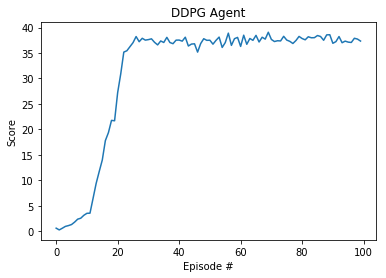

In [9]:
# setup agent hyperparameters
config = AgentConfig()
config.batch_size = 512
config.lr_critic = 3e-4
print(config)

# train the agent for 150 episodes and show the scores
start_time = time.time()
ddpg_agent = Agent(reacher_env.state_size, reacher_env.action_size, config)
scores = ddpg(ddpg_agent, 150)
print("Environment solved in {:.2f} seconds".format(time.time() - start_time))

# save the checkpoints
torch.save(ddpg_agent.actor_online.state_dict(), 'checkpoints/checkpoint_actor.pth')
torch.save(ddpg_agent.critic_online.state_dict(), 'checkpoints/checkpoint_critic.pth')

plot_scores(scores, "DDPG Agent")

### Watch a Smart Agent

Watch an agent control 20 independent articulating arms using the agent trained above.

In [6]:
def run_smart_agent(agent):
    state = reacher_env.reset(False)
    score = 0
    while True:
        action = agent.act(state, add_noise=False)
        next_state, reward, done, _ = reacher_env.step(action)
        score += sum(reward) / len(reward)                               # update the score
        state = next_state                             # roll over the state to next time step
        if any(done):                                       # exit loop if episode finished
            break
    print("Score: {}".format(score))

In [7]:
config = AgentConfig()
config.batch_size = 512
config.lr_critic = 3e-4
ddpg_agent = Agent(reacher_env.state_size, reacher_env.action_size, config)
ddpg_agent.actor_online.load_state_dict(torch.load('./checkpoints/checkpoint_actor.pth'))
ddpg_agent.critic_online.load_state_dict(torch.load('./checkpoints/checkpoint_critic.pth'))
run_smart_agent(ddpg_agent)

Score: 39.53999911621213


In [12]:
reacher_env.env.close()